# Download data and process interferogram stack
George Brencher

## Create and configure environment

In [1]:
import os

#if not os.path.exists('/srv/conda/envs/isce2'):
#    !mamba create -n isce2 --file conda-linux-64.lock
#    !conda activate isce2
#    !python -m ipykernel install --user --name=isce2

In [ ]:
# Note--if processing on headless server, need to run the following for the stack processor to work: 
#!pip install opencv-python-headless

In [5]:
import logging
log = logging.getLogger()
log.setLevel(logging.WARN)
import getpass
import asf_search as asf
import isce
from os import listdir
import numpy as np;
import matplotlib.pyplot as plt;
import rasterio as rio;
import rasterio.plot;
from rasterio import logging
from osgeo import gdal;

Make sure kernel is set to 'Python [conda env:isce2]'

'topStack' is a Sentinel 1 interferogram stack processing workflow which has been contributed to isce. To get access to topsStack, which does not come with the conda install of isce, we need to clone isce2 from github. 

In [ ]:
#!git clone https://github.com/isce-framework/isce2.git

In [2]:
# Set Environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)

# Set path to topsStack workflow in isce source directory
CWD = os.getcwd()
os.environ['PATH']+=f':{CWD}/isce2/contrib/stack/topsStack'
print(os.environ['PATH'])

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
/srv/conda/envs/isce2/bin:/srv/conda/condabin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/bin:/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/applications:/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack


In [3]:
# Make sure stack processing scripts are in path
!which stackSentinel.py

/home/jovyan/Friendly-InSAR-time-series/isce2/contrib/stack/topsStack/stackSentinel.py


In [4]:
# Do downloads and processing in a temporary folder to avoid clogging the disk
os.chdir('/tmp')
os.makedirs('orbital')
os.makedirs('SLC')
os.makedirs('DEM')
os.makedirs('AUX')

## Download scenes

In [5]:
#check disk space prior to downloading SLCs
!df -h ~

Filesystem      Size  Used Avail Use% Mounted on
/dev/sdc         15G  243M   15G   2% /home/jovyan


In [6]:
os.chdir('/tmp/SLC')

In [7]:
# Update this with your NASA Earthdata login to download SLC data
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

# prevent DEBUG messages
logging.getLogger("urllib3").setLevel(logging.WARNING)

try:
    user_pass_session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

 ········


Success!


In [8]:
# Create a persistent .netrc file for downloading NASA datasets (ISCE retrieves SRTM by default)
# https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget
!echo "machine urs.earthdata.nasa.gov login {EARTHDATA_LOGIN} password {EARTHDATA_PASSWORD}" > ~/.netrc
!chmod 0600 ~/.netrc

In [9]:
# Set area of interest with two corner points of a box [lat, lon]

# southwestern corner
lower_left = [27.875165, 86.892988]

# northeastern corner
upper_right = [27.918111, 86.949540]

aoi = f'POLYGON(({lower_left[1]} {lower_left[0]}, {lower_left[1]} {upper_right[0]}, {upper_right[1]} {upper_right[0]}, {upper_right[1]} {lower_left[0]}, {lower_left[1]} {lower_left[0]}))'

In [10]:
# Set platform, start and end dates, flight direction, and processing level
opts = {'platform': asf.PLATFORM.SENTINEL1, 
        'start': '2021-08-01T00:00:00Z', 
        'end': '2021-09-01T00:00:00Z', 
        'flightDirection': 'A',
        'processingLevel': 'SLC',
        'frame': 84}

In [11]:
# search for scenes
results = asf.geo_search(intersectsWith=aoi, **opts)
print(f'{len(results)} scenes found')

3 scenes found


In [12]:
# Download scenes 
#Each scene is ~4 GB

results.download(path = '/tmp/SLC', session=user_pass_session)

In [13]:
# Create a list of zipped SLCs. Assume there are no other files with .zip extension in tmp/SLC
tmp = listdir('/tmp/SLC')

scenes = []
for file in tmp:
    if file[-4:]=='.zip':
        scenes.append(file[:-4])
        
print(scenes)

['S1A_IW_SLC__1SDV_20210830T121356_20210830T121423_039459_04A972_A57E', 'S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5', 'S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0']


## Download precise orbitals 

In [14]:
os.chdir('/tmp/orbital')

In [15]:
# necessary?
!wget -nc https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
!chmod +x fetchOrbit.py

--2022-03-06 23:10:09--  https://raw.githubusercontent.com/isce-framework/isce2/main/contrib/stack/topsStack/fetchOrbit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5054 (4.9K) [text/plain]
Saving to: ‘fetchOrbit.py’

fetchOrbit.py       100%[===================>]   4.94K  --.-KB/s    in 0s      

2022-03-06 23:10:10 (26.5 MB/s) - ‘fetchOrbit.py’ saved [5054/5054]



In [16]:
for file in scenes:
    os.system(f'./fetchOrbit.py -i {file}')

Reference time:  2021-08-30 12:14:23
Satellite name:  S1A
Reference time:  2021-08-18 12:14:22
Satellite name:  S1A
Reference time:  2021-08-06 12:14:21
Satellite name:  S1A


### Also download calibration auxliary file
A calibration auxliary (AUX_CAL) file is used for antenna pattern correction to compensate the range phase offset of SAFE products with IPF verison 002.36 (mainly for images acquired before March 2015). 

In [17]:
os.chdir('/tmp/AUX')
!wget https://qc.sentinel1.groupcls.com/product/S1A/AUX_CAL/2014/09/08/S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ

--2022-03-06 23:10:12--  https://qc.sentinel1.groupcls.com/product/S1A/AUX_CAL/2014/09/08/S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ
Resolving qc.sentinel1.groupcls.com (qc.sentinel1.groupcls.com)... 20.74.8.22
Connecting to qc.sentinel1.groupcls.com (qc.sentinel1.groupcls.com)|20.74.8.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494159 (483K)
Saving to: ‘S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ’

S1A_AUX_CAL_V201409 100%[===================>] 482.58K  --.-KB/s    in 0.05s   

2022-03-06 23:10:13 (9.51 MB/s) - ‘S1A_AUX_CAL_V20140908T000000_G20190626T100201.SAFE.TGZ’ saved [494159/494159]



## Specify or download digital elevation file

In [18]:
os.chdir('/tmp/DEM')

In [19]:
!which dem.py

/srv/conda/envs/isce2/lib/python3.9/site-packages/isce/applications/dem.py


In [20]:
print(f'lower left (southwest): {lower_left}, upper right (northwest): {upper_right}')

lower left (southwest): [27.875165, 86.892988], upper right (northwest): [27.918111, 86.94954]


In [21]:
# feed dem.py ingeter coordinates surrounding the aoi, using the following structure: lower lat, upper lat, left lon, right lon 

!dem.py -a stitch -b 27 28 86 87 -r -s 1 -c
!rm demLat*.dem demLat*.dem.xml demLat*.dem.vrt

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
curl -n  -L -c $HOME/.earthdatacookie -b $HOME/.earthdatacookie -k -f -O http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/N27E086.SRTMGL1.hgt.zip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   267  100   267    0     0    917      0 --:--:-- --:--:-- --:--:--   917
100   498  100   498    0     0     21      0  0:00:23  0:00:23 --:--:--   108
100   291    0   291    0     0     12      0 --:--:--  0:00:24 --:--:--     0
100   267  100   267    0   

## Stack processing 

In [22]:
os.chdir('/tmp')

In [23]:
# Look at options for stack processing

!stackSentinel.py -h

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
usage: stackSentinel.py [-h] [-H] -s SLC_DIRNAME -o ORBIT_DIRNAME -a
                        AUX_DIRNAME [-w WORK_DIR] -d DEM [-m REFERENCE_DATE]
                        [-c NUM_CONNECTIONS] [-n SWATH_NUM] [-b BBOX]
                        [-t TEXT_CMD] [-x EXCLUDE_DATES] [-i INCLUDE_DATES]
                        [--start_date STARTDATE] [--stop_date STOPDATE]
                        [-z AZIMUTHLOOKS] [-r RANGELOOKS] [-f FILTSTRENGTH]
                        [--snr_misreg_threshold SNRTHRESHOLD]
                        [-p POLARIZATION] [-C {geometry,NESD}]
              

In [24]:
!stackSentinel.py -s /tmp/SLC/ -o /tmp/orbital/ -a /tmp/AUX/ -d /tmp/DEM/demLat_N27_N28_Lon_E086_E087.dem.wgs84 -r 9 -z 2 -c 2 --bbox '27 28 86.3 87' -f 0.2

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Number of SAFE files found: 3
Number of SAFE files to be used (cover BBOX): 3
*****************************************
Number of dates : 3
List of dates : 
['20210806', '20210818', '20210830']
date      south      north
20210806 26.30085 28.33621
20210818 26.301233 28.336365
20210830 26.300856 28.336529
*****************************************
The overlap region among all dates (based on the preview kml files):
 South   North   East  West 
26.301233 28.33621 86.205772 89.061569
*****************************************
All dates (3)
['20210806', '20210818', '20210830']



In [25]:
os.chdir('/tmp/run_files')

In [26]:
%%time
# First run took 42 min
!sh run_01_unpack_topo_reference

Completed Parsing the Configuration file
Functions to be executed:
['Function-1', 'Function-2']
Running: Sentinel1_TOPS
['--dirname', '/tmp/SLC/S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0.zip', '--swaths', '1 2 3', '--orbitdir', '/tmp/orbital', '--outdir', '/tmp/reference', '--auxdir', '/tmp/AUX', '--bbox', '27 28 86.3 87', '--pol', 'vv']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Input XML files:  ['/vsizip//tmp/SLC/S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0.zip/S1A_IW_SLC__1SDV_20210806T121354_20210806T121421_039109_049D70_B0A0.SAFE/annotation/s1a-iw1-slc-vv-202108

In [27]:
%%time
!sh run_02_unpack_secondary_slc

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: Sentinel1_TOPS
['--dirname', '/tmp/SLC/S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5.zip', '--swaths', '1 2 3', '--orbitdir', '/tmp/orbital', '--outdir', '/tmp/secondarys/20210818', '--auxdir', '/tmp/AUX', '--bbox', '27 28 86.3 87', '--pol', 'vv']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Input XML files:  ['/vsizip//tmp/SLC/S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5.zip/S1A_IW_SLC__1SDV_20210818T121355_20210818T121422_039284_04A383_54D5.SAFE/annotation/s1a-iw1-slc-vv-20210818t1

In [28]:
%%time
!sh run_03_average_baseline

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: computeBaseline
['--reference', '/tmp/reference/', '--secondary', '/tmp/secondarys/20210818', '--baseline_file', '/tmp/baselines/20210806_20210818/20210806_20210818.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
B

In [29]:
%%time
!sh run_04_extract_burst_overlaps

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Overlap 0 start time - IW-1 2021-08-06 12:14:05.069835 subset
Overlap 0 stop time - IW-1 2021-08-06 12:14:05.384335 subset
Overlap 0 number of lines - IW-1 154 subset
Overlap 0 number of valid lines - IW-1 117 subset
Top:  ['/tmp/reference/overlap/IW1/burst_top_01_02.slc']
Bottom:  ['/tmp/reference/overlap/IW1/burst_bot_01_02.slc']
Overlap 1 start time - IW-1 2021-08-06 12:14:07.828391 subset
Overlap 1 stop time - IW-1 2021-08-06 12:14:08.140836 subset
Overlap 1 number of lines - IW-1 153 subset
Overlap 1 number of valid lines - IW-1 117 subset
Top:  ['/tmp/reference/overl

In [30]:
%%time
# First run took 2 min
!sh run_05_overlap_geo2rdr

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/tmp/secondarys/20210818', '--reference', '/tmp/reference', '--geom_referenceDir', '/tmp/geom_reference', '--coregSLCdir', '/tmp/coreg_secondarys/20210818', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
CPU mode
Estimated burst offset:  0
Overlap pair 0: Burst 0 of reference matched with Burst 0 of secondary
Additional time offset applied in geo2rdr: 0.0 secs
Additional range offset applied in geo2rdr: 0.0 m
Turning off bistatic delay correction term by default.
API open (WR): /tmp/coreg_sec

In [31]:
%%time
# First run took 8 min
!sh run_06_overlap_resample

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/tmp/secondarys/20210818', '--reference', '/tmp/reference', '--coregdir', '/tmp/coreg_secondarys/20210818', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Estimated burst offset:  0
Shifts:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: -1}
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Chi squared: 0.000033
Polynomial Order: 5 - by - 3 
13231.9	-694.453	37.0086	1.12534	
-51368.8	2612.67	-126.264	-4.09993	
49855.9	-2454.85	105.774	3.6755	
-3.92437e-09	4.73863e-09	-1.67

In [32]:
%%time
# First run took 13 min
!sh run_07_pairs_misreg

Completed Parsing the Configuration file
Functions to be executed:
['Function-1', 'Function-2', 'Function-3', 'Function-4']
Running: generateIgram
['--reference', '/tmp/reference', '--secondary', '/tmp/coreg_secondarys/20210818', '--interferogram', '/tmp/coarse_interferograms/20210806_20210818', '--interferogram_prefix', 'int', '--overlap']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 6
minReference,maxReference 1 6
minBurst, maxBurst:  1 6
matching burst numbers:  1 1
multiply
read
No range offsets provided
rdict:  {'rangeOff1': '/tmp/reference/overlap/IW1/range_bot_01_02.off', 'rangeOff2

In [33]:
%%time
!sh run_08_timeseries_misreg


Rank of design matrix: 2
Design matrix is full rank.
RMSE : 0.0005158476997166879 pixels

Estimated offsets with respect to the stack reference date

20210806 : 0.0
20210818 : -0.003972111997918129
20210830 : 0.0008550393458831261


Rank of design matrix: 2
Design matrix is full rank.
RMSE : 0.012133136014142341 pixels

Estimated offsets with respect to the stack reference date

20210806 : 0.0
20210818 : 0.13346449714995337
20210830 : -0.02426627220908245

CPU times: user 9.93 ms, sys: 13.5 ms, total: 23.4 ms
Wall time: 1.08 s


In [34]:
%%time
# First run took 13 min
!sh run_09_fullBurst_geo2rdr

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/tmp/secondarys/20210818', '--reference', '/tmp/reference', '--geom_referenceDir', '/tmp/geom_reference', '--coregSLCdir', '/tmp/coreg_secondarys/20210818', '--azimuth_misreg', '/tmp/misreg/azimuth/dates/20210818.txt', '--range_misreg', '/tmp/misreg/range/dates/20210818.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
CPU mode
Estimated burst offset:  0
Overlap pair 0: Burst 0 of reference matched with Burst 0 of secondary
Burst 0 of reference matched with Burst 0 of secondary
Additional time offset a

In [35]:
%%time
# First run took 9 min
!sh run_10_fullBurst_resample

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/tmp/secondarys/20210818', '--reference', '/tmp/reference', '--coregdir', '/tmp/coreg_secondarys/20210818', '--azimuth_misreg', '/tmp/misreg/azimuth/dates/20210818.txt', '--range_misreg', '/tmp/misreg/range/dates/20210818.txt']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Estimated burst offset:  0
Shifts:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: -1}
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Chi squared: 0.000033
Polynomial Order: 5 - by - 3 
13231.9	-694.453	37.0086	1

In [36]:
%%time
!sh run_11_extract_stack_valid_region

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
creating  /tmp/stack
checking the number of bursts in coreg_secondarys against the one in reference
all secondary images have the same number of bursts as the reference
******************
swath:  1
/tmp/coreg_secondarys/20210818
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
/tmp/coreg_secondarys/20210830
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
writing  /tmp/stack/IW1.xml
CPU times: user 56.3 ms, sys: 18.7 ms, total: 75 ms
Wall time: 3.88 s


In [37]:
%%time
!sh run_12_merge_reference_secondary_slc

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/tmp/stack', '--inp_reference', '/tmp/reference', '--dirname', '/tmp/reference', '--name_pattern', 'burst*slc', '--outfile', '/tmp/merged/SLC/20210806/20210806.slc', '--method', 'top', '--valid_only', '--use_virtual_files', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 7
False
Skipping multi-looking ....
Completed Parsing the Configuration file
Functions to be executed:

In [38]:
%%time
# First run took 3 min
!sh run_13_generate_burst_igram

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: generateIgram
['--reference', '/tmp/reference', '--secondary', '/tmp/coreg_secondarys/20210818', '--interferogram', '/tmp/interferograms/20210806_20210818', '--interferogram_prefix', 'fine']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
minSecondary,maxSecondary 1 7
minReference,maxReference 1 7
minBurst, maxBurst:  1 7
matching burst numbers:  1 1
multiply
read
No range offsets provided
matching burst numbers:  2 2
multiply
read
No range offsets provided
matching burst numbers:  3 3
multiply
read
No range offsets provided
match

In [39]:
%%time
!sh run_14_merge_burst_igram

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/tmp/stack', '--inp_reference', '/tmp/interferograms/20210806_20210818', '--dirname', '/tmp/interferograms/20210806_20210818', '--name_pattern', 'fine*int', '--outfile', '/tmp/merged/interferograms/20210806_20210818/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 7
True
Multil

In [40]:
%%time
# First run took 7 min
!sh run_15_filter_coherence

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/tmp/merged/interferograms/20210806_20210818/fine.int', '--filt', '/tmp/merged/interferograms/20210806_20210818/filt_fine.int', '--coh', '/tmp/merged/interferograms/20210806_20210818/filt_fine.cor', '--strength', '0.2', '--slc1', '/tmp/merged/SLC/20210806/20210806.slc.full', '--slc2', '/tmp/merged/SLC/20210818/20210818.slc.full', '--complex_coh', '/tmp/merged/interferograms/20210806_20210818/fine.cor', '--range_looks', '9', '--azimuth_looks', '2']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022

In [ ]:
%%time
# First run took 36 min. WARNING: This step may not finish running even if all output are created. 
!sh run_16_unwrap

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/tmp/merged/interferograms/20210806_20210818/filt_fine.int', '--unw', '/tmp/merged/interferograms/20210806_20210818/filt_fine.unw', '--coh', '/tmp/merged/interferograms/20210806_20210818/filt_fine.cor', '--reference', '/tmp/reference', '--defomax', '2', '--rlks', '9', '--alks', '2', '--method', 'snaphu']
This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
unwrapping method :  snaphu

snaphu v1.4.2
Reading wrapped phase from file /tmp/merged/interferograms/20210806_20210818/filt_fine.int
No weight file specified.  Ass

## Geocode results

In [23]:
os.chdir('/tmp/merged/interferograms/')
tmp = listdir('/tmp/merged/interferograms/')

int_list = []
for i in tmp:
    if len(i) == 17 and i[8]=='_':
        int_list.append(i)

print(int_list)

['20210806_20210830', '20210818_20210830', '20210806_20210818']


In [20]:
# Not needed for MintPy
# Loop through interferograms, coherence, and connected components and use gdalwarp to geocode and reproject 

#for i in int_list:
#    !gdalwarp -of VRT -geoloc  -te 86.3 27 87 28 -tr 0.001 0.001 -srcnodata "0 0" -dstnodata "0 0"  -r near -t_srs EPSG:4326 /tmp/merged/interferograms/$i/filt_fine.unw.vrt /tmp/merged/interferograms/$i/geo_filt_fine.unw.vrt
#    !gdalwarp -of VRT -geoloc  -te 86.3 27 87 28 -tr 0.001 0.001 -srcnodata "0 0" -dstnodata "0 0"  -r near -t_srs EPSG:4326 /tmp/merged/interferograms/$i/fine.cor.vrt /tmp/merged/interferograms/$i/geo_fine.cor.vrt
#    !gdalwarp -of VRT -geoloc  -te 86.3 27 87 28 -tr 0.001 0.001 -srcnodata "0 0" -dstnodata "0 0"  -r near -t_srs EPSG:4326 /tmp/merged/interferograms/$i/fine.cor.vrt /tmp/merged/interferograms/$i/geo_fine.cor.vrt

## Sanity check

/tmp/ipykernel_4068/874271690.py:10: RuntimeWarning: divide by zero encountered in log
  im0 = ax[0].imshow(np.log(amp));


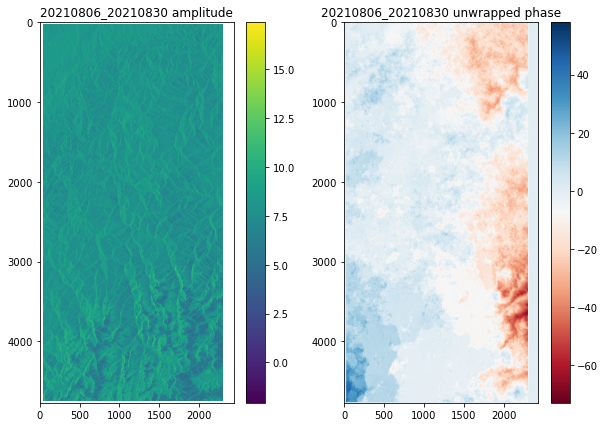

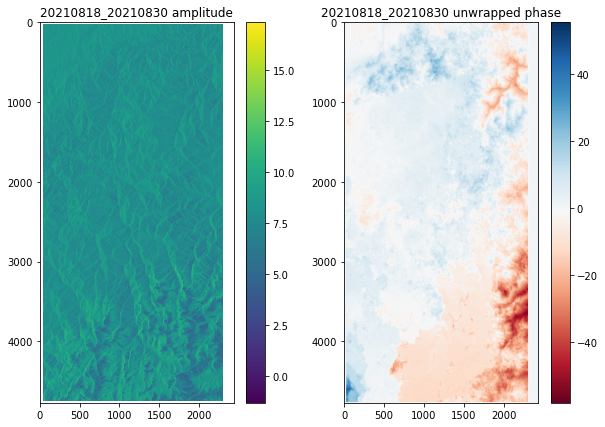

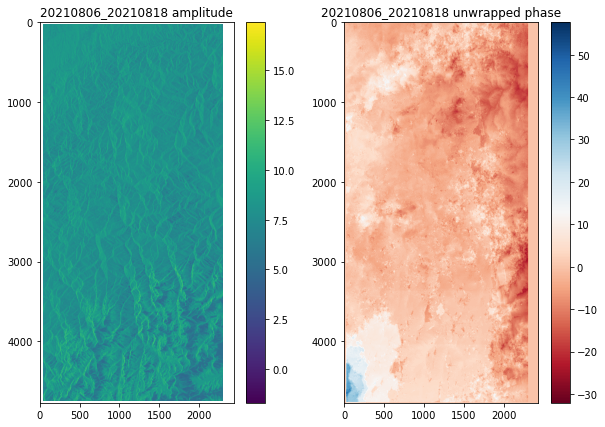

In [24]:
# Plot interferograms

for i in int_list:
    os.chdir(f'/tmp/merged/interferograms/{i}')
    with rasterio.open('filt_fine.unw.vrt') as src:
        amp = src.read(1)
        phase = src.read(2)

    f, ax = plt.subplots(1, 2, figsize=(10,7))
    im0 = ax[0].imshow(np.log(amp));
    f.colorbar(im0, ax=ax[0])
    ax[0].set_title(f'{i} amplitude')
    
    im1 = ax[1].imshow(phase, cmap ='RdBu')
    f.colorbar(im1, ax=ax[1])
    ax[1].set_title(f'{i} unwrapped phase')

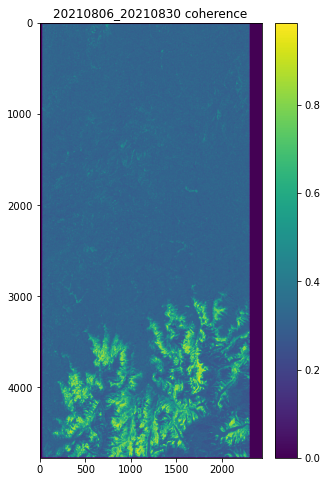

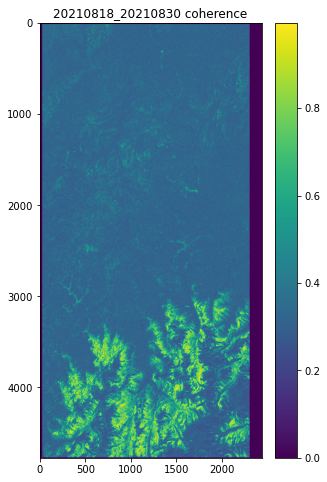

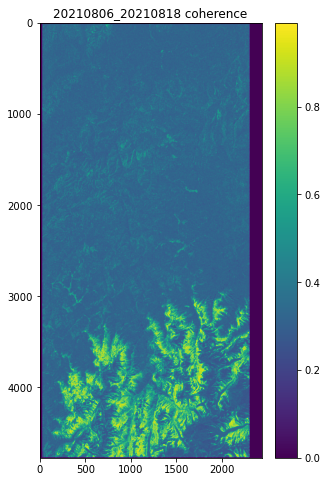

In [25]:
# Plot coherence

for i in int_list:
    os.chdir(f'/tmp/merged/interferograms/{i}')
    with rasterio.open('fine.cor.vrt') as src:
        coherence = src.read(2)

    fig, ax = plt.subplots(figsize=(5,8))
    im0 = ax.imshow(coherence);
    f.colorbar(im0, ax=ax)
    ax.set_title(f'{i} coherence')